# Setup libraries and environment

In [55]:
import numpy as np
import glob
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import pickle
import numpy as np
import cv2
import time
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader

from torchviz import make_dot

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object
print("Pytorch version:", torch.version.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("device:", device)

Pytorch version: 2.0.1
CUDA available: True
CUDA version: 11.7
device: cuda:0


# Read in data in a dataframe and preprocess it

In [2]:
# readin annotations file
df = pd.read_excel('annotations.xlsx')

# Extract the first number using regular expression and create a new column
df['Schweißnahtnummer'] = df['img_path'].str.extract(r'(\d+)')
df['Cutout name'] = (df['Schweißnahtnummer'])
df['Cutout name'] = df['Cutout name'] + '_' + df['filename']
# Interchange the substring in the img_path column
df['img_path'] = df['img_path'].str.replace('../data/raw/hx_fsw/images', 'hx_training_classify')

# Get column names except the first three columns
other_columns = df.columns[3:]
# Reorder columns by concatenating the other columns with the first three columns
df = df[other_columns.tolist() + df.columns[:3].tolist()]

# Reorder columns by moving "Schweißnahtnummer" to the front
df_col = df['Schweißnahtnummer']
df.drop(columns=['Schweißnahtnummer'], inplace=True)
df.insert(0, 'Schweißnahtnummer', df_col)
df_col = df['Cutout name']
df.drop(columns=['Cutout name'], inplace=True)
df.insert(1, 'Cutout name', df_col)
df_col = df['img_path']
df.drop(columns=['img_path'], inplace=True)
df.insert(8, 'img_path', df_col)
# rename column Cutout name to Cutout_name
df.rename(columns={'Cutout name': 'Cutout_name'}, inplace=True)

# Create the column Parametergruppe
# Create a dictionary to map the ranges of Schweißnahtnummer to Parametergruppe values
# change the datatype of the column Schweißnahtnummer to int
df['Schweißnahtnummer'] = df['Schweißnahtnummer'].astype(int)
group_mapping = {
    range(1, 17): 1,
    range(17,19): 0,
    range(19, 35): 2,
    range(35, 51): 3,
    range(51, 67): 4,
    range(67, 83): 5,
    range(83, 99): 6,
    range(99, 115): 7
}
# Apply the mapping to create the Parametergruppe column
df['Parametergruppe'] = df['Schweißnahtnummer'].apply(lambda x: next((val for key, val in group_mapping.items() if x in key), None))
df['Parametergruppe'] = df['Parametergruppe'].astype(int)
# change the position of the column Parametergruppe to second
df_col = df['Parametergruppe']
df.drop(columns=['Parametergruppe'], inplace=True)
df.insert(1, 'Parametergruppe', df_col)

# Extract the numbers from the Cutout_name column using regular expressions
df[['Num1', 'Num2', 'Num3']] = df['Cutout_name'].str.extract(r'(\d+)_.*-(\d+)-(\d+)\.JPG')
# Convert the extracted columns to numeric
df[['Num1', 'Num2', 'Num3']] = df[['Num1', 'Num2', 'Num3']].astype(int)
# Sort the DataFrame based on the extracted numbers
df = df.sort_values(['Num1', 'Num2', 'Num3'])
# Drop the extracted number columns if not needed
df = df.drop(['Num1', 'Num2', 'Num3'], axis=1)
# Reset the index if desired
df = df.reset_index(drop=True)

# drop the columns "Unnamed: 0" and "begin" and "end"
df.drop(columns=['Unnamed: 0', 'begin', 'end'], inplace=True)

C:\Users\JanHe\AppData\Local\Temp\ipykernel_22956\3813462484.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df['img_path'] = df['img_path'].str.replace('../data/raw/hx_fsw/images', 'hx_training_classify')


In [3]:
# create the column containing the tensors of the images
# create a new column called img_array_color that reads in the image which is located in the img_path column
df['img_array_color'] = df['img_path'].map(lambda x: np.asarray(Image.open(x)))
# normalize the images in the img_array_color_resized column
df['img_array_color_normalized'] = df['img_array_color'].map(lambda x: x/255)
# transform the images to permuted tensors with the shape (3, 224, 224)
df['img_tensor_color'] = df['img_array_color_normalized'].map(lambda x: torch.from_numpy(x).permute(2, 0, 1))

In [4]:
""" # takes very long -> only uncomment if needed
# save the dataframe to csv and excel file
df.to_csv('df.csv')
df.to_excel('df.xlsx')

# show the dataframe
df """

" # takes very long -> only uncomment if needed\n# save the dataframe to csv and excel file\ndf.to_csv('df.csv')\ndf.to_excel('df.xlsx')\n\n# show the dataframe\ndf "

# Gesamten Datensatz aufteilen in Validierungs- und Testdatensatz

In [5]:
# create a custom dataset that inherits from torch.utils.data.Dataset
class DataFrameDataset(Dataset):
    def __init__(self, df):
        self.img = np.stack(df['img_tensor_color'].values)       # stack the images in the img_tensor_color column
        self.label_raw = df.iloc[:,7].values
        self.label = torch.tensor(self.label_raw, dtype=torch.int64)

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        return self.img[idx,:,:,:], self.label[idx]
    
all_data = DataFrameDataset(df)

In [6]:
""" # just to check if the dataset got read in correctly
test = all_data.__getitem__(8455)
print(test)
print(test[0].dtype)
print(test[0].shape)
print(test[1].type)
print(test[1].shape) """

' # just to check if the dataset got read in correctly\ntest = all_data.__getitem__(8455)\nprint(test)\nprint(test[0].dtype)\nprint(test[0].shape)\nprint(test[1].type)\nprint(test[1].shape) '

In [7]:
# split the entire data randomly into train (60%), validation (20%) and test (20%) data
train_data, val_data, test_data = torch.utils.data.random_split(all_data, [int(0.6*len(all_data)), int(0.2*len(all_data)), int(0.2*len(all_data))])

batch_size = 32

# create data loaders
train_data_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True)
val_data_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, pin_memory=True)

print(len(train_data_loader) * batch_size)
print(len(val_data_loader) * batch_size)
print(len(test_loader) * batch_size)

5088
1696
1696


# ResNet18 laden

In [8]:
model = models.resnet18(pretrained=False)   # load resnet18 model
num_features = model.fc.in_features         # extract fc layers features
model.fc = nn.Linear(num_features, 2)       # (num_of_class == 2)
model = model.to(device)
criterion = nn.CrossEntropyLoss()           #(set loss function)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

c:\Users\JanHe\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\JanHe\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [58]:
# visualize model
print(model)
make_dot(model(torch.randn(1, 3, 224, 224).to(device)), params=dict(model.named_parameters())).render("torchviz_model_visualization", format="png")

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

'torchviz_model_visualization.png'

# Training the model

In [9]:
# Trainingsfunktion definieren
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
    for epoch in range(epochs):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()   # set model to training mode
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device).float()  # Convert input tensor to torch.cuda.FloatTensor
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        model.eval()    # set model to evaluation mode
        num_correct = 0
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device).float()  # Convert input tensor to torch.cuda.FloatTensor
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output, targets)
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1], targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)
        print('Epoch: {}, Training Loss: {:.4f}, Validation Loss: {:.4f}, accuracy = {:.4f}'.format(epoch+1, training_loss,
        valid_loss, num_correct / num_examples))

In [10]:
""" # load model if already trained
if os.path.exists('saved_models/model.pth'):
    model_state_dict = torch.load('saved_models/model.pth')
    model.load_state_dict(model_state_dict)
    print('Model loaded successfully!')
# train model if there is no saved model
else:
    print("No model loaded --> Train new model:")
    train(model, optimizer, criterion, train_data_loader, val_data_loader, epochs=20, device=device)
    torch.save(model.state_dict(), 'saved_models/model.pth')
    print('Model trained and saved successfully!') """

' # load model if already trained\nif os.path.exists(\'saved_models/model.pth\'):\n    model_state_dict = torch.load(\'saved_models/model.pth\')\n    model.load_state_dict(model_state_dict)\n    print(\'Model loaded successfully!\')\n# train model if there is no saved model\nelse:\n    print("No model loaded --> Train new model:")\n    train(model, optimizer, criterion, train_data_loader, val_data_loader, epochs=20, device=device)\n    torch.save(model.state_dict(), \'saved_models/model.pth\')\n    print(\'Model trained and saved successfully!\') '

# Testing the model (Vorhersagen treffen)

In [11]:
""" # test the model for one image specified by its index in the dataframe
img_idx = 3000

labels = ['Grat OK', 'Grat zu stark']

img = df['img_tensor_color'][img_idx]
img = img.to(device).float()
img = torch.unsqueeze(img, 0)       # add a dimension (the 1) for the batch (1, 3, 224, 224)

model.eval()
prediction = F.softmax(model(img), dim=1)
prediction = prediction.argmax()        # gibt den index des höchsten Wertes zurück
print("Prediction:",labels[prediction])

# show the image
def imshow(torch_img, title=img_idx):
    torch_img = torch_img.cpu()                         # move the image to the CPU
    np_img = torch_img.squeeze(0).permute(1, 2, 0)      # remove the batch dimension and permute the dimensions (put channel from first position to last position)
    np_img = np_img.detach().numpy()                    # convert the tensor to a numpy array
    np_img = np_img * 255                               # unnormalize the image
    np_img = np_img.astype(np.uint8)                    # convert the image to unsigned integer type
    
    # Display the image with the original size (300 x 100)
    plt.imshow(np_img)
    plt.title("Cutout Nr: " + str(title))
    # Adjust spacing between subplots
    plt.tight_layout()
    # Show the figure with both subplots
    plt.show()

imshow(img, img_idx)

# print corresponding row of the dataframe
print(df.iloc[img_idx]) """

' # test the model for one image specified by its index in the dataframe\nimg_idx = 3000\n\nlabels = [\'Grat OK\', \'Grat zu stark\']\n\nimg = df[\'img_tensor_color\'][img_idx]\nimg = img.to(device).float()\nimg = torch.unsqueeze(img, 0)       # add a dimension (the 1) for the batch (1, 3, 224, 224)\n\nmodel.eval()\nprediction = F.softmax(model(img), dim=1)\nprediction = prediction.argmax()        # gibt den index des höchsten Wertes zurück\nprint("Prediction:",labels[prediction])\n\n# show the image\ndef imshow(torch_img, title=img_idx):\n    torch_img = torch_img.cpu()                         # move the image to the CPU\n    np_img = torch_img.squeeze(0).permute(1, 2, 0)      # remove the batch dimension and permute the dimensions (put channel from first position to last position)\n    np_img = np_img.detach().numpy()                    # convert the tensor to a numpy array\n    np_img = np_img * 255                               # unnormalize the image\n    np_img = np_img.astype(np

In [12]:
# create test function (for better readability and to avoid code duplication)
def test(model, test_loader, device):
    model.eval()
    num_correct = 0
    num_examples = 0
    for batch in test_loader:
        inputs, targets = batch
        inputs = inputs.to(device).float()  # Convert input tensor to torch.cuda.FloatTensor
        output = model(inputs)
        targets = targets.to(device)
        correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1], targets).view(-1)
        num_correct += torch.sum(correct).item()
        num_examples += correct.shape[0]
    print('Test accuracy: {:.4f}'.format(num_correct / num_examples))
    return num_correct / num_examples

In [13]:
# test the model on the test data
accuracy_all = test(model, test_loader, device)

Test accuracy: 0.5384


# Teildatensätze aufteilen in Trainings und Validierungsdatensätze

In [14]:
# create a dataframe for each parametergroup
df_1 = df[df['Parametergruppe'] == 1]
df_2 = df[df['Parametergruppe'] == 2]
df_3 = df[df['Parametergruppe'] == 3]
df_4 = df[df['Parametergruppe'] == 4]
df_5 = df[df['Parametergruppe'] == 5]
df_6 = df[df['Parametergruppe'] == 6]
df_7 = df[df['Parametergruppe'] == 7]

len(df_1), len(df_2), len(df_3), len(df_4), len(df_5), len(df_6), len(df_7)

(950, 966, 858, 1532, 1066, 1522, 1430)

In [15]:
# create a dataset for each parametergroup
data_1 = DataFrameDataset(df_1)
data_2 = DataFrameDataset(df_2)
data_3 = DataFrameDataset(df_3)
data_4 = DataFrameDataset(df_4)
data_5 = DataFrameDataset(df_5)
data_6 = DataFrameDataset(df_6)
data_7 = DataFrameDataset(df_7)

len(data_1), len(data_2), len(data_3), len(data_4), len(data_5), len(data_6), len(data_7)

(950, 966, 858, 1532, 1066, 1522, 1430)

In [16]:
# unangepasste validierungs- und testdatensatzlänge
int(0.2*len(data_1)), int(0.2*len(data_2)), int(0.2*len(data_3)), int(0.2*len(data_4)), int(0.2*len(data_5)), int(0.2*len(data_6)), int(0.2*len(data_7))

(190, 193, 171, 306, 213, 304, 286)

In [17]:
# unangepasste trainingsdatensatzlänge
int(0.6*len(data_1)), int(0.6*len(data_2)), int(0.6*len(data_3)), int(0.6*len(data_4)), int(0.6*len(data_5)), int(0.6*len(data_6)), int(0.6*len(data_7))

(570, 579, 514, 919, 639, 913, 858)

In [18]:
# angepasste trainingsdatensatzlänge
int(0.6*len(data_1)), int(0.601*len(data_2)), int(0.602*len(data_3)), int(0.601*len(data_4)), int(0.601*len(data_5)), int(0.601*len(data_6)), int(0.6*len(data_7))

(570, 580, 516, 920, 640, 914, 858)

In [19]:
batch_size = 32

# split the data for each dataframe randomly into train (60%), validation (20%) and test (20%) data
train_data_1, val_data_1, test_data_1 = torch.utils.data.random_split(data_1, [int(0.6*len(data_1)), int(0.2*len(data_1)), int(0.2*len(data_1))])
train_data_2, val_data_2, test_data_2 = torch.utils.data.random_split(data_2, [int(0.601*len(data_2)), int(0.2*len(data_2)), int(0.2*len(data_2))])
train_data_3, val_data_3, test_data_3 = torch.utils.data.random_split(data_3, [int(0.602*len(data_3)), int(0.2*len(data_3)), int(0.2*len(data_3))])
train_data_4, val_data_4, test_data_4 = torch.utils.data.random_split(data_4, [int(0.601*len(data_4)), int(0.2*len(data_4)), int(0.2*len(data_4))])
train_data_5, val_data_5, test_data_5 = torch.utils.data.random_split(data_5, [int(0.601*len(data_5)), int(0.2*len(data_5)), int(0.2*len(data_5))])
train_data_6, val_data_6, test_data_6 = torch.utils.data.random_split(data_6, [int(0.601*len(data_6)), int(0.2*len(data_6)), int(0.2*len(data_6))])
train_data_7, val_data_7, test_data_7 = torch.utils.data.random_split(data_7, [int(0.6*len(data_7)), int(0.2*len(data_7)), int(0.2*len(data_7))])

# create data loaders for each dataset
train_data_loader_1 = DataLoader(train_data_1, batch_size=batch_size, shuffle=True, pin_memory=True)
val_data_loader_1 = DataLoader(val_data_1, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader_1 = DataLoader(test_data_1, batch_size=batch_size, shuffle=True, pin_memory=True)

train_data_loader_2 = DataLoader(train_data_2, batch_size=batch_size, shuffle=True, pin_memory=True)
val_data_loader_2 = DataLoader(val_data_2, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader_2 = DataLoader(test_data_2, batch_size=batch_size, shuffle=True, pin_memory=True)

train_data_loader_3 = DataLoader(train_data_3, batch_size=batch_size, shuffle=True, pin_memory=True)
val_data_loader_3 = DataLoader(val_data_3, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader_3 = DataLoader(test_data_3, batch_size=batch_size, shuffle=True, pin_memory=True)

train_data_loader_4 = DataLoader(train_data_4, batch_size=batch_size, shuffle=True, pin_memory=True)
val_data_loader_4 = DataLoader(val_data_4, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader_4 = DataLoader(test_data_4, batch_size=batch_size, shuffle=True, pin_memory=True)

train_data_loader_5 = DataLoader(train_data_5, batch_size=batch_size, shuffle=True, pin_memory=True)
val_data_loader_5 = DataLoader(val_data_5, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader_5 = DataLoader(test_data_5, batch_size=batch_size, shuffle=True, pin_memory=True)

train_data_loader_6 = DataLoader(train_data_6, batch_size=batch_size, shuffle=True, pin_memory=True)
val_data_loader_6 = DataLoader(val_data_6, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader_6 = DataLoader(test_data_6, batch_size=batch_size, shuffle=True, pin_memory=True)

train_data_loader_7 = DataLoader(train_data_7, batch_size=batch_size, shuffle=True, pin_memory=True)
val_data_loader_7 = DataLoader(val_data_7, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader_7 = DataLoader(test_data_7, batch_size=batch_size, shuffle=True, pin_memory=True)

print("Anzahl Trainingsbilder:", len(train_data_loader_1) * batch_size, len(train_data_loader_2) * batch_size, len(train_data_loader_3) * batch_size, len(train_data_loader_4) * batch_size, len(train_data_loader_5) * batch_size, len(train_data_loader_6) * batch_size, len(train_data_loader_7) * batch_size)
print("Anzahl Validierungsbilder:",len(val_data_loader_1) * batch_size, len(val_data_loader_2) * batch_size, len(val_data_loader_3) * batch_size, len(val_data_loader_4) * batch_size, len(val_data_loader_5) * batch_size, len(val_data_loader_6) * batch_size, len(val_data_loader_7) * batch_size)
print("Anzahl Testbilder:", len(test_loader_1) * batch_size, len(test_loader_2) * batch_size, len(test_loader_3) * batch_size, len(test_loader_4) * batch_size, len(test_loader_5) * batch_size, len(test_loader_6) * batch_size, len(test_loader_7) * batch_size)
print("")
print("Anzahl Traningsbatches:", len(train_data_loader_1), len(train_data_loader_2), len(train_data_loader_3), len(train_data_loader_4), len(train_data_loader_5), len(train_data_loader_6), len(train_data_loader_7))
print("Anzahl Validierungsbatches:", len(val_data_loader_1), len(val_data_loader_2), len(val_data_loader_3), len(val_data_loader_4), len(val_data_loader_5), len(val_data_loader_6), len(val_data_loader_7))
print("Anzahl Testbatches:", len(test_loader_1), len(test_loader_2), len(test_loader_3), len(test_loader_4), len(test_loader_5), len(test_loader_6), len(test_loader_7))

Anzahl Trainingsbilder: 576 608 544 928 640 928 864
Anzahl Validierungsbilder: 192 224 192 320 224 320 288
Anzahl Testbilder: 192 224 192 320 224 320 288

Anzahl Traningsbatches: 18 19 17 29 20 29 27
Anzahl Validierungsbatches: 6 7 6 10 7 10 9
Anzahl Testbatches: 6 7 6 10 7 10 9


# Methode 1: Finetuning
## Kein Continual Learning
### Base accuracy (Task der gerade trainiert wurde) testen
### General accuracy (Tasks die nicht gerade trainiert wurden) testen

In [20]:
# train on every parameter group and test on every test data
# create empty numpy arrays for the results
test_results = np.zeros((7,7))
# loop through all training datasets
for train_data in range(1,8):
    # set the correct train and val data loader
    if train_data == 1:
        train_data_loader = train_data_loader_1
        val_data_loader = val_data_loader_1
    elif train_data == 2:
        train_data_loader = train_data_loader_2
        val_data_loader = val_data_loader_2
    elif train_data == 3:
        train_data_loader = train_data_loader_3
        val_data_loader = val_data_loader_3
    elif train_data == 4:
        train_data_loader = train_data_loader_4
        val_data_loader = val_data_loader_4
    elif train_data == 5:
        train_data_loader = train_data_loader_5
        val_data_loader = val_data_loader_5
    elif train_data == 6:
        train_data_loader = train_data_loader_6
        val_data_loader = val_data_loader_6
    elif train_data == 7:
        train_data_loader = train_data_loader_7
        val_data_loader = val_data_loader_7

    print("##########################################################################")
    print("Train on dataset of parametergroup", train_data)
    train(model, optimizer, criterion, train_data_loader, val_data_loader, epochs=20, device=device)

    # loop through all test datasets
    for test_data in range(1,8):
        # use every test data loader
        if test_data == 1:
            test_loader = test_loader_1
        elif test_data == 2:
            test_loader = test_loader_2
        elif test_data == 3:
            test_loader = test_loader_3
        elif test_data == 4:
            test_loader = test_loader_4
        elif test_data == 5:
            test_loader = test_loader_5
        elif test_data == 6:
            test_loader = test_loader_6
        elif test_data == 7:
            test_loader = test_loader_7
        
        # test the model on the test data
        print("")
        print("Test model trained on train data " + str(train_data) + " with test data " + str(test_data))
        # call test function
        test_results[train_data-1, test_data-1] = test(model, test_loader, device)

##########################################################################
Train on dataset of parametergroup 1
Epoch: 1, Training Loss: 0.7063, Validation Loss: 0.5941, accuracy = 0.7158
Epoch: 2, Training Loss: 0.4899, Validation Loss: 0.7566, accuracy = 0.7158
Epoch: 3, Training Loss: 0.4167, Validation Loss: 0.7162, accuracy = 0.4895
Epoch: 4, Training Loss: 0.3718, Validation Loss: 0.3997, accuracy = 0.8263
Epoch: 5, Training Loss: 0.2883, Validation Loss: 2.0542, accuracy = 0.2842
Epoch: 6, Training Loss: 0.2416, Validation Loss: 0.3564, accuracy = 0.8421
Epoch: 7, Training Loss: 0.2163, Validation Loss: 0.3009, accuracy = 0.8684
Epoch: 8, Training Loss: 0.1675, Validation Loss: 0.2245, accuracy = 0.9158
Epoch: 9, Training Loss: 0.1353, Validation Loss: 0.2425, accuracy = 0.8895
Epoch: 10, Training Loss: 0.1036, Validation Loss: 0.2813, accuracy = 0.9105
Epoch: 11, Training Loss: 0.0880, Validation Loss: 3.5387, accuracy = 0.3789
Epoch: 12, Training Loss: 0.0608, Validation Loss:

In [21]:
test_results

array([[0.93684211, 0.73056995, 0.74269006, 0.65686275, 0.74178404,
        0.66447368, 0.53496503],
       [0.80526316, 0.99481865, 0.8128655 , 0.56862745, 0.81220657,
        0.83552632, 0.75524476],
       [0.66315789, 0.71502591, 1.        , 0.57189542, 0.76525822,
        0.79934211, 0.77272727],
       [0.7       , 0.74093264, 0.90643275, 1.        , 0.85446009,
        0.6875    , 0.6993007 ],
       [0.63157895, 0.8238342 , 0.49122807, 0.66013072, 0.98122066,
        0.55921053, 0.60839161],
       [0.53157895, 0.71502591, 0.85380117, 0.81699346, 0.8685446 ,
        1.        , 0.84615385],
       [0.77894737, 0.86528497, 0.84210526, 0.74509804, 0.74647887,
        0.94736842, 0.98251748]])

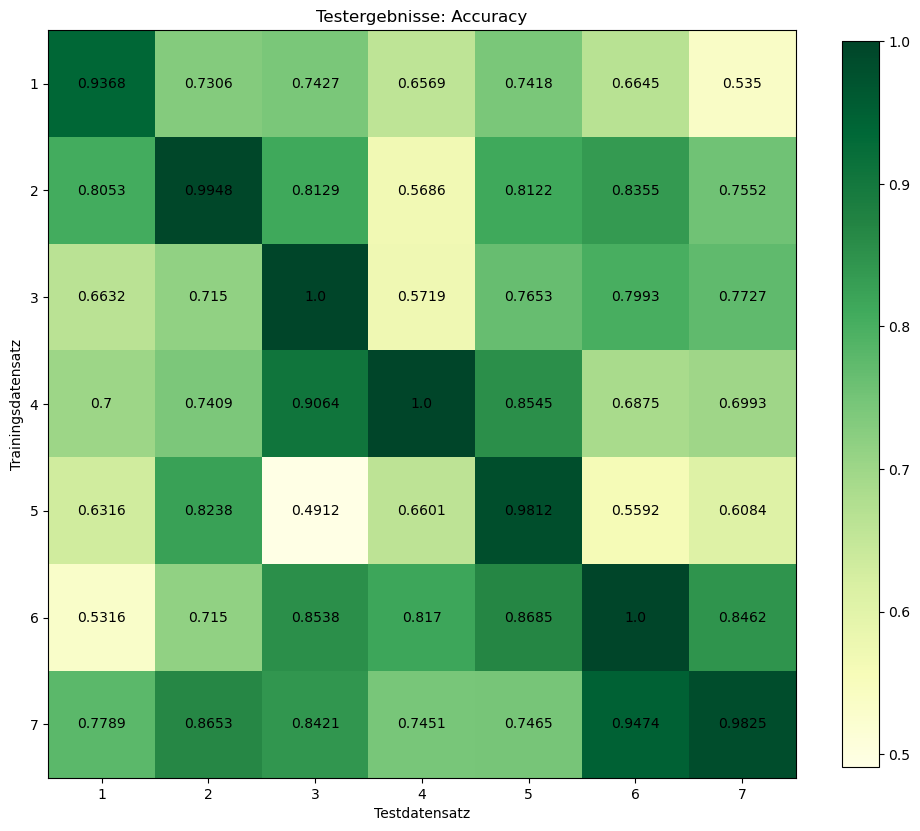

In [22]:
# plot the test results
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(test_results, cmap="YlGn")
ax.set_xticks(np.arange(7))
ax.set_yticks(np.arange(7))
ax.set_xticklabels(["1", "2", "3", "4", "5", "6", "7"])
ax.set_yticklabels(["1", "2", "3", "4", "5", "6", "7"])
ax.set_xlabel("Testdatensatz")
ax.set_ylabel("Trainingsdatensatz")
ax.set_title("Testergebnisse: Accuracy")
for i in range(7):
    for j in range(7):
        text = ax.text(j, i, round(test_results[i, j], 4), ha="center", va="center", color="black")
fig.tight_layout()
# add a colorbar
cbar = ax.figure.colorbar(im, ax=ax, shrink=0.8)
plt.show()

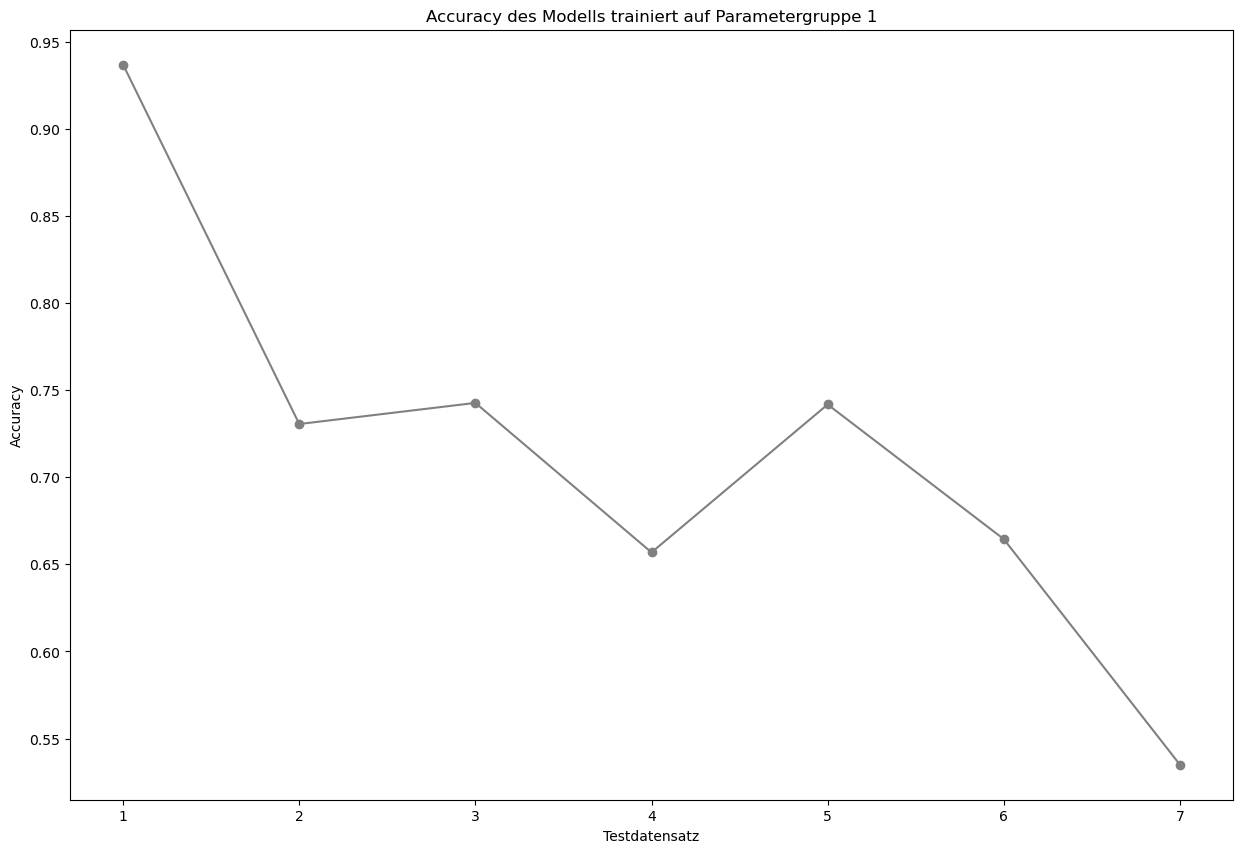

In [54]:
# plot the accuracy of the model trained on the chosen parameter group over all seven test datasets
parameter_group = 1     # choose the parameter group    

fig, ax = plt.subplots(figsize=(15,10))
ax.plot(range(1,8), test_results[parameter_group-1,:], marker="o", color= "gray")
ax.set_xlabel("Testdatensatz")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy des Modells trainiert auf Parametergruppe " + str(parameter_group))
plt.show()

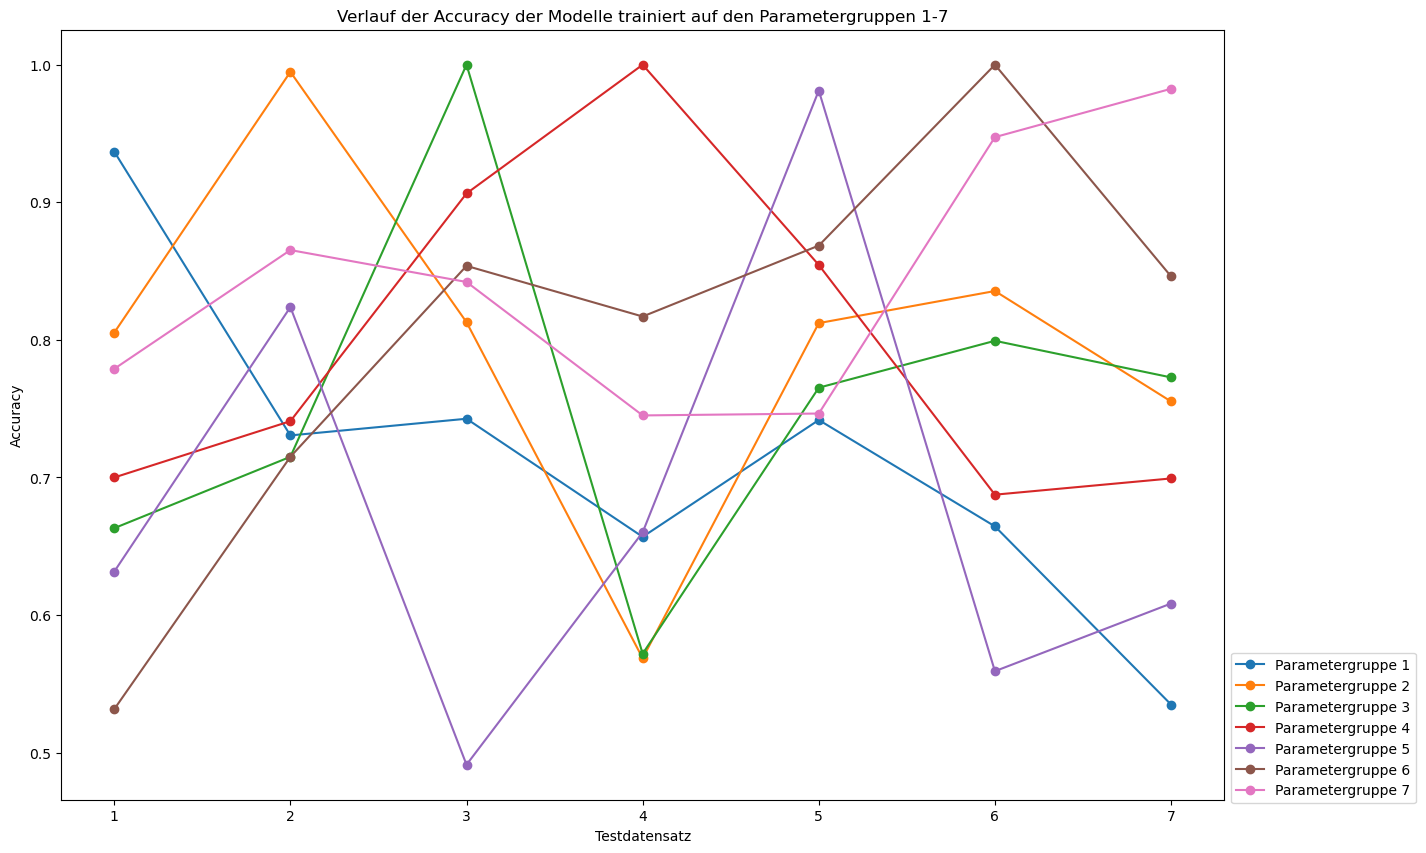

In [53]:
# plot the accuracy of each model trained on a parameter group over all seven test datasets
fig, ax = plt.subplots(figsize=(15,10))
for i in range(7):
    ax.plot(range(1,8), test_results[i,:], marker="o", label="Parametergruppe " + str(i+1))
ax.set_xlabel("Testdatensatz")
ax.set_ylabel("Accuracy")
ax.set_title("Verlauf der Accuracy der Modelle trainiert auf den Parametergruppen 1-7")
ax.legend(bbox_to_anchor=(1, 0.2))
plt.show()

# Methode 2: EWC
## Continual Learning
### Continual Learning backward accuracy (Tasks testen die bereits trainiert wurden) testen
### Continual Learning forward accuracy (Tasks testen die noch nicht trainiert wurden) testen